# Einsum decomposition

This notebook shows a way to decompose [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) into a subset of operations (expand_dims, squeeze, transpose, extended matrix multiplication).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Operator explanation with equation bac,cd,def->ebc

The operator einsum takes an equation and some inputs. Every letter involved in the equation is a loop. Let's see on one example.

In [2]:
import numpy

m1 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 10
m2 = numpy.arange(0, 4).astype(numpy.float32).reshape((2, 2)) + 100
m3 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 1000

equation = "bac,cd,def->ebc"
truth = numpy.einsum(equation, m1, m2, m3)
truth

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

This summation is equalent to:

In [3]:
res = numpy.zeros((2, 2, 2))
for a in range(0, 2):
    for b in range(0, 2):
        for c in range(0, 2):
            for d in range(0, 2):
                for e in range(0, 2):
                    for f in range(0, 2):
                        res[e, b, c] += m1[b, a, c] * m2[c, d] * m3[d, e, f]
res

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]])

Theoritically, this summation is in this case has a cost of $O(N^6)$. However this simple computation is usually much longer than using matrix multiplications along the path. $O(N^4)$ is the cost of the heaviest matrix multiplication in this case). But to do that, the equation needs to be decomposed into a sequence of matrix multiplications.

## Decomposition of bac,cd,def->ebc

In [4]:
import numpy
from mlprodict.testing.einsum_impl import (
    decompose_einsum_equation, apply_einsum_sequence)

In [5]:
m1 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 10
m2 = numpy.arange(0, 4).astype(numpy.float32).reshape((2, 2)) + 100
m3 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 1000

In [6]:
seq = decompose_einsum_equation("bac,cd,def->ebc", m1.shape, m2.shape, m3.shape)

In [7]:
from jyquickhelper import RenderJsDot
RenderJsDot(seq.to_dot(size=7))

Then the result can be obtained as follows:

In [8]:
apply_einsum_sequence(seq, m1, m2, m3)

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

## operator matmul

This operator can be used to represent either a multiplication, either a matrix multiplication but it applies only on arrays with the same number of dimensions. It can be broken into multiplication of matrix multiplication.

In [9]:
seq_broken = decompose_einsum_equation("bac,cd,def->ebc", m1.shape, m2.shape, m3.shape, 
                                       strategy='numpy', clean=True)
RenderJsDot(seq_broken.to_dot(size=7))

Operator *transpose_mm* is a regular transposition, it takes two inputs but only tranposes the first input before returning it. Operator *batch_dot* is a matrix multiplication. It is left that way on purpose as it may be implemented with function dot or gemm. The operator distinguishes between 3 kind of axes: batch axes, kept axes, sum(mation) axes. It then reshapes both input matrices with 3D tensors, batch axis, row axis, column axis to use function [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).

## onnxruntime

In [10]:
import onnx
from onnx import helper, numpy_helper
from onnxruntime import InferenceSession


def make_model(equation):
    model = helper.make_model(
        opset_imports=[helper.make_operatorsetid('', 13)],
        graph=helper.make_graph(
            name='einsum_test',
            inputs=[helper.make_tensor_value_info("X", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Y", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Z", onnx.TensorProto.FLOAT, None)],
            outputs=[helper.make_tensor_value_info("A", onnx.TensorProto.FLOAT, None)],
            nodes=[
                helper.make_node("Einsum", ["X", "Y", "Z"], ["A"], equation=equation)
            ]
        )
    )
    return model


model = make_model("bac,cd,def->ebc")
sess = InferenceSession(model.SerializeToString())

In [11]:
sess.run(None, {'X': m1, 'Y': m2, 'Z': m3})[0]

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### Benchmark

It clearly shows the summation done with the basic algorithm is the slowest.

In [12]:
from mlprodict.onnxrt.validate.validate_helper import measure_time
from tqdm import tqdm
from pandas import DataFrame


def raw_product(m1, m2, m3):
    N = m1.shape[0]
    res = numpy.zeros((N, N, N))
    for a in range(0, N):
        for b in range(0, N):
            for c in range(0, N):
                for d in range(0, N):
                    for e in range(0, N):
                        for f in range(0, N):
                            res[e, b, c] += m1[b, a, c] * m2[c, d] * m3[d, e, f]
    return res


equation = "bac,cd,def->ebc"
sess = None
seq = None 

results = []
for N in tqdm([2, 3, 4, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]):
    m1 = numpy.random.randn(N, N, N)
    m2 = numpy.random.randn(N, N)
    m3 = numpy.random.randn(N, N, N)
    
    if seq is None:
        seq = decompose_einsum_equation(
            equation, m1.shape, m2.shape, m3.shape, clean=True)
    if sess is None:
        model = make_model(equation)
        sess = InferenceSession(model.SerializeToString())

    res = measure_time(lambda x: numpy.einsum(equation, *x, optimize=True),
                       [m1, m2, m3],
                       repeat=10, number=10)
    res['name'] = "numpy.einsum"
    res["N"] = N
    results.append(res)

    if N <= 4:
        res = measure_time(lambda x: raw_product(*x),
                           [m1, m2, m3],
                           repeat=10, number=10)
        res['name'] = "raw_product"
        res["N"] = N
        results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                       [m1, m2, m3],
                       repeat=10, number=10)
    res['name'] = "custom_einsum"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                       [m1, m2, m3],
                       repeat=10, number=10)
    res['name'] = "tr/resh/dot"
    res["N"] = N
    results.append(res)    

    res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1], 'Z': x[2]}),
                       [m1.astype(numpy.float32), m2.astype(numpy.float32),
                        m3.astype(numpy.float32)],
                       repeat=10, number=10)
    res['name'] = "onnxruntime"
    res["N"] = N
    results.append(res)    
    

df = DataFrame(results)
df.tail()

100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N
50,0.004894,0.000222,0.004628,0.005283,10,10,0.048943,onnxruntime,50
51,0.263068,0.001402,0.261303,0.265483,10,10,2.630676,numpy.einsum,55
52,0.053470,0.001030,0.051849,0.054855,10,10,0.534695,custom_einsum,55
53,0.045314,0.004231,0.041232,0.053182,10,10,0.453135,tr/resh/dot,55
54,0.008238,0.000564,0.007009,0.008989,10,10,0.082384,onnxruntime,55


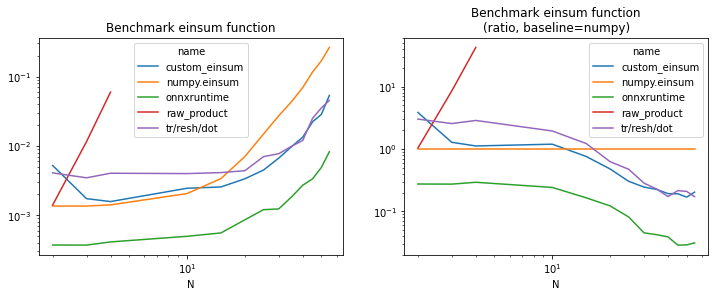

In [13]:
import matplotlib.pyplot as plt

piv = df.pivot("N", "name", "average")
piv2 = piv.copy()
np = piv["numpy.einsum"]
for c in piv2.columns:
    piv2[c] /= np
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
piv.plot(logy=True, logx=True, ax=ax[0])
ax[0].set_title("Benchmark einsum function")
piv2.plot(logy=True, logx=True, ax=ax[1])
ax[1].set_title("Benchmark einsum function\n(ratio, baseline=numpy)");

Version `tr/resh/dot` is an implementation based on the decomposition of a simplified einsum into a sequence of transpose, reshape, (batch_)dot or mul operations.